# Multivariate Time Series Anomaly Detection Framework

This notebook implements a complete anomaly detection framework combining:
- **Geometric Masking** for data augmentation
- **Transformer Architecture** for feature extraction and reconstruction
- **Contrastive Loss** for learning discriminative representations
- **GAN** for handling contaminated training data

**Instructions**: Simply click "Runtime" → "Run All" to execute everything!


In [27]:
# Install dependencies
%pip install -q torch numpy pandas scikit-learn matplotlib seaborn tqdm scipy

# Check GPU availability
import torch
if torch.cuda.is_available():
    print(f"✅ GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"   CUDA Version: {torch.version.cuda}")
else:
    print("⚠️  No GPU detected. Training will be slower on CPU.")


✅ GPU Available: Tesla T4
   GPU Memory: 14.74 GB
   CUDA Version: 12.6


## 1. Imports and Setup


In [28]:
import numpy as np
import pandas as pd
import os
import math
import random
import json
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_curve, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print("✅ All imports successful!")


✅ All imports successful!


## 2. Data Loading and Preprocessing


In [29]:
class TimeSeriesDataset(Dataset):
    """PyTorch Dataset for time series data."""

    def __init__(self, data, labels=None, window_size=100, stride=1):
        self.window_size = window_size
        self.stride = stride

        # Create sliding windows
        self.windows = []
        self.window_labels = []

        for i in range(0, len(data) - window_size + 1, stride):
            window = data[i:i + window_size]
            self.windows.append(window)

            if labels is not None:
                window_label = 1 if np.any(labels[i:i + window_size] == 1) else 0
                self.window_labels.append(window_label)
            else:
                self.window_labels.append(0)

        self.windows = np.array(self.windows)
        self.window_labels = np.array(self.window_labels)

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window = torch.FloatTensor(self.windows[idx])
        label = torch.LongTensor([self.window_labels[idx]])[0]
        return window, label


def create_synthetic_data(n_samples=10000, n_features=10, anomaly_ratio=0.1):
    """Create synthetic multivariate time series data."""
    np.random.seed(42)

    # Generate normal data with temporal correlation
    normal_data = np.random.randn(n_samples, n_features)
    for i in range(1, n_samples):
        normal_data[i] = 0.7 * normal_data[i-1] + 0.3 * normal_data[i]

    # Generate labels
    n_anomalies = int(n_samples * anomaly_ratio)
    labels = np.zeros(n_samples)
    anomaly_indices = np.random.choice(n_samples, n_anomalies, replace=False)
    labels[anomaly_indices] = 1

    # Add anomalies
    data = normal_data.copy()
    for idx in anomaly_indices:
        data[idx] += np.random.randn(n_features) * 3

    # Split train/test
    train_size = int(0.7 * n_samples)
    train_data = data[:train_size]
    test_data = data[train_size:]
    train_labels = labels[:train_size]
    test_labels = labels[train_size:]

    return train_data, test_data, train_labels, test_labels


def preprocess_data(train_data, test_data, normalize=True):
    """Preprocess time series data."""
    if normalize:
        scaler = StandardScaler()
        train_data = scaler.fit_transform(train_data)
        test_data = scaler.transform(test_data)
        return train_data, test_data, scaler
    return train_data, test_data, None


def create_dataloaders(train_data, test_data, train_labels=None, test_labels=None,
                      window_size=100, batch_size=32, stride=1, normalize=True):
    """Create PyTorch DataLoaders."""
    train_data, test_data, scaler = preprocess_data(train_data, test_data, normalize)

    train_dataset = TimeSeriesDataset(train_data, train_labels, window_size, stride)
    test_dataset = TimeSeriesDataset(test_data, test_labels, window_size, stride)

    pin_memory = torch.cuda.is_available()
    num_workers = 2 if torch.cuda.is_available() else 0

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        pin_memory=pin_memory, num_workers=num_workers
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False,
        pin_memory=pin_memory, num_workers=num_workers
    )

    return train_loader, test_loader, scaler

print("✅ Data loading functions defined!")


✅ Data loading functions defined!


In [30]:
class GeometricMasking:
    """Geometric masking for time series data augmentation."""

    def __init__(self, mask_ratio=0.15, mask_mode='random'):
        self.mask_ratio = mask_ratio
        self.mask_mode = mask_mode

    def random_mask(self, x):
        batch_size, seq_len, n_features = x.shape
        mask = torch.ones_like(x)
        n_mask = int(seq_len * n_features * self.mask_ratio)
        flat_indices = torch.randperm(seq_len * n_features)[:n_mask]
        for idx in flat_indices:
            t = idx // n_features
            f = idx % n_features
            mask[:, t, f] = 0
        return x * mask, mask

    def block_mask(self, x):
        batch_size, seq_len, n_features = x.shape
        mask = torch.ones_like(x)
        block_length = int(seq_len * self.mask_ratio)
        if block_length == 0:
            block_length = 1
        start_pos = random.randint(0, max(1, seq_len - block_length))
        mask[:, start_pos:start_pos + block_length, :] = 0
        return x * mask, mask

    def channel_mask(self, x):
        batch_size, seq_len, n_features = x.shape
        mask = torch.ones_like(x)
        n_channels_to_mask = max(1, int(n_features * self.mask_ratio))
        channels_to_mask = torch.randperm(n_features)[:n_channels_to_mask]
        mask[:, :, channels_to_mask] = 0
        return x * mask, mask

    def temporal_mask(self, x):
        batch_size, seq_len, n_features = x.shape
        mask = torch.ones_like(x)
        n_steps_to_mask = max(1, int(seq_len * self.mask_ratio))
        steps_to_mask = torch.randperm(seq_len)[:n_steps_to_mask]
        mask[:, steps_to_mask, :] = 0
        return x * mask, mask

    def __call__(self, x):
        if self.mask_mode == 'random':
            return self.random_mask(x)
        elif self.mask_mode == 'block':
            return self.block_mask(x)
        elif self.mask_mode == 'channel':
            return self.channel_mask(x)
        elif self.mask_mode == 'temporal':
            return self.temporal_mask(x)
        else:
            return self.random_mask(x)


class AdaptiveMasking:
    """Adaptive masking that combines multiple strategies."""

    def __init__(self, mask_ratio=0.15):
        self.mask_ratio = mask_ratio
        self.maskers = {
            'random': GeometricMasking(mask_ratio, 'random'),
            'block': GeometricMasking(mask_ratio, 'block'),
            'channel': GeometricMasking(mask_ratio, 'channel'),
            'temporal': GeometricMasking(mask_ratio, 'temporal')
        }

    def __call__(self, x):
        strategy = random.choice(list(self.maskers.keys()))
        return self.maskers[strategy](x)

print("✅ Geometric masking classes defined!")


✅ Geometric masking classes defined!


## 4. Transformer Architecture


In [31]:
class PositionalEncoding(nn.Module):
    """Positional encoding for transformer."""

    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class TransformerEncoder(nn.Module):
    """Transformer encoder for feature extraction."""

    def __init__(self, d_model=128, nhead=8, num_layers=3, dim_feedforward=512, dropout=0.1, input_dim=None):
        super().__init__()
        self.d_model = d_model
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=False
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)
        if input_dim is not None:
            self.input_projection = nn.Linear(input_dim, d_model)
        else:
            self.input_projection = None

    def forward(self, x):
        x = x.transpose(0, 1)
        if x.size(-1) != self.d_model:
            if self.input_projection is None:
                self.input_projection = nn.Linear(x.size(-1), self.d_model).to(x.device)
            x = self.input_projection(x)
        x = self.pos_encoder(x)
        encoded = self.transformer_encoder(x)
        return encoded


class TransformerDecoder(nn.Module):
    """Transformer decoder for sequence reconstruction."""

    def __init__(self, d_model=128, nhead=8, num_layers=3, dim_feedforward=512,
                 dropout=0.1, output_dim=None):
        super().__init__()
        self.d_model = d_model
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=False
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)
        self.output_dim = output_dim
        if output_dim is not None:
            self.output_projection = nn.Linear(d_model, output_dim)

    def forward(self, memory, tgt=None):
        if tgt is None:
            tgt = memory
        else:
            if tgt.size(-1) != self.d_model:
                if not hasattr(self, 'tgt_projection'):
                    self.tgt_projection = nn.Linear(tgt.size(-1), self.d_model).to(tgt.device)
                tgt = self.tgt_projection(tgt)
        tgt = self.pos_encoder(tgt)
        decoded = self.transformer_decoder(tgt, memory)
        if self.output_dim is not None:
            decoded = self.output_projection(decoded)
        return decoded


class TransformerAutoencoder(nn.Module):
    """Complete transformer autoencoder."""

    def __init__(self, n_features, d_model=128, nhead=8, num_layers=3,
                 dim_feedforward=512, dropout=0.1, window_size=100):
        super().__init__()
        self.n_features = n_features
        self.d_model = d_model
        self.window_size = window_size

        self.encoder = TransformerEncoder(
            d_model=d_model, nhead=nhead, num_layers=num_layers,
            dim_feedforward=dim_feedforward, dropout=dropout, input_dim=n_features
        )
        self.decoder = TransformerDecoder(
            d_model=d_model, nhead=nhead, num_layers=num_layers,
            dim_feedforward=dim_feedforward, dropout=dropout, output_dim=n_features
        )

    def forward(self, x, mask=None):
        if mask is not None:
            x = x * mask
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        reconstructed = decoded.transpose(0, 1)
        return reconstructed, encoded

    def encode(self, x):
        return self.encoder(x)

    def get_representation(self, x):
        encoded = self.encode(x)
        representation = encoded.mean(dim=0)
        return representation

print("✅ Transformer architecture defined!")


✅ Transformer architecture defined!


In [32]:
class InfoNCE(nn.Module):
    """InfoNCE loss (Noise Contrastive Estimation)."""

    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, query, key, negatives=None):
        query = F.normalize(query, p=2, dim=1)
        key = F.normalize(key, p=2, dim=1)
        pos_sim = torch.sum(query * key, dim=1) / self.temperature

        if negatives is not None:
            negatives = F.normalize(negatives, p=2, dim=1)
            neg_sim = torch.matmul(query, negatives.t()) / self.temperature
            logits = torch.cat([pos_sim.unsqueeze(1), neg_sim], dim=1)
        else:
            batch_size = query.size(0)
            all_keys = key
            logits = torch.matmul(query, all_keys.t()) / self.temperature

        labels = torch.zeros(logits.size(0), dtype=torch.long).to(query.device)
        loss = F.cross_entropy(logits, labels)
        return loss

print("✅ Contrastive loss defined!")


✅ Contrastive loss defined!


## 6. GAN Components


In [33]:
class Generator(nn.Module):
    """Generator network for GAN."""

    def __init__(self, latent_dim=100, hidden_dim=256, output_dim=128, seq_len=100):
        super().__init__()
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        self.output_dim = output_dim

        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 4)
        self.fc4 = nn.Linear(hidden_dim * 4, seq_len * output_dim)

        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim * 2)
        self.bn3 = nn.BatchNorm1d(hidden_dim * 4)
        self.dropout = nn.Dropout(0.2)

    def forward(self, z):
        x = F.relu(self.bn1(self.fc1(z)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = torch.tanh(self.fc4(x))
        batch_size = z.size(0)
        x = x.view(batch_size, self.seq_len, self.output_dim)
        return x


class Discriminator(nn.Module):
    """Discriminator network for GAN."""

    def __init__(self, input_dim=128, hidden_dim=256, seq_len=100):
        super().__init__()
        self.seq_len = seq_len

        self.conv1 = nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(hidden_dim, hidden_dim * 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(hidden_dim * 2, hidden_dim * 4, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim * 2)
        self.bn3 = nn.BatchNorm1d(hidden_dim * 4)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(hidden_dim * 4, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = self.pool(x).squeeze(-1)
        output = torch.sigmoid(self.fc(x))
        return output


class GANLoss(nn.Module):
    """GAN loss functions."""

    def __init__(self, gan_mode='vanilla'):
        super().__init__()
        self.gan_mode = gan_mode

    def __call__(self, prediction, target_is_real):
        if self.gan_mode == 'vanilla':
            target = torch.ones_like(prediction) if target_is_real else torch.zeros_like(prediction)
            loss = F.binary_cross_entropy(prediction, target)
        elif self.gan_mode == 'lsgan':
            target = torch.ones_like(prediction) if target_is_real else torch.zeros_like(prediction)
            loss = F.mse_loss(prediction, target)
        else:
            raise ValueError(f"Unknown GAN mode: {self.gan_mode}")
        return loss

print("✅ GAN components defined!")


✅ GAN components defined!


## 7. Complete Model


In [34]:
class AnomalyDetectionModel(nn.Module):
    """Complete anomaly detection model."""

    def __init__(self, n_features, d_model=128, nhead=8, num_layers=3,
                 dim_feedforward=512, dropout=0.1, window_size=100,
                 latent_dim=100, use_gan=True):
        super().__init__()

        self.n_features = n_features
        self.d_model = d_model
        self.window_size = window_size
        self.use_gan = use_gan

        self.transformer_ae = TransformerAutoencoder(
            n_features=n_features, d_model=d_model, nhead=nhead,
            num_layers=num_layers, dim_feedforward=dim_feedforward,
            dropout=dropout, window_size=window_size
        )

        if use_gan:
            self.generator = Generator(
                latent_dim=latent_dim, hidden_dim=256,
                output_dim=d_model, seq_len=window_size
            )
            self.discriminator = Discriminator(
                input_dim=d_model, hidden_dim=256, seq_len=window_size
            )

        self.masking = AdaptiveMasking(mask_ratio=0.15)

    def forward(self, x, use_mask=True):
        mask = None
        if use_mask and self.training:
            x_masked, mask = self.masking(x)
        else:
            x_masked = x
        reconstructed, encoded = self.transformer_ae(x_masked, mask)
        return reconstructed, encoded, mask

    def encode(self, x):
        return self.transformer_ae.get_representation(x)

    def generate(self, batch_size, device):
        if not self.use_gan:
            raise ValueError("GAN not enabled")
        z = torch.randn(batch_size, self.generator.latent_dim).to(device)
        fake_repr = self.generator(z)
        return fake_repr

    def discriminate(self, encoded):
        if not self.use_gan:
            raise ValueError("GAN not enabled")
        encoded = encoded.transpose(0, 1)
        return self.discriminator(encoded)

    def compute_reconstruction_error(self, x, reconstructed):
        mse = torch.mean((x - reconstructed) ** 2, dim=(1, 2))
        return mse

print("✅ Complete model defined!")


✅ Complete model defined!


## 8. Configuration and Data Loading


In [35]:
# Configuration
config = {
    'n_features': 10,
    'window_size': 100,
    'd_model': 128,
    'nhead': 8,
    'num_layers': 3,
    'dim_feedforward': 512,
    'dropout': 0.1,
    'batch_size': 64 if torch.cuda.is_available() else 32,
    'num_epochs': 50,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'contrastive_weight': 0.5,
    'use_gan': True,
    'gan_g_step': 2,
    'latent_dim': 100,
    'use_synthetic': True
}

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    print(f"✅ Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️  Using CPU")

# Load data
print("\n📊 Loading data...")
train_data, test_data, train_labels, test_labels = create_synthetic_data(
    n_samples=10000, n_features=config['n_features'], anomaly_ratio=0.1
)

train_loader, test_loader, scaler = create_dataloaders(
    train_data, test_data, train_labels, test_labels,
    window_size=config['window_size'],
    batch_size=config['batch_size'],
    stride=1,
    normalize=True
)

n_features = train_data.shape[1]
print(f"✅ Data loaded: {len(train_loader.dataset)} training samples, {len(test_loader.dataset)} test samples")
print(f"   Features: {n_features}, Window size: {config['window_size']}")


✅ Using GPU: Tesla T4

📊 Loading data...
✅ Data loaded: 6901 training samples, 2901 test samples
   Features: 10, Window size: 100


## 9. Model Initialization


In [36]:
# Create model
print("🔧 Creating model...")
model = AnomalyDetectionModel(
    n_features=n_features,
    d_model=config['d_model'],
    nhead=config['nhead'],
    num_layers=config['num_layers'],
    dim_feedforward=config['dim_feedforward'],
    dropout=config['dropout'],
    window_size=config['window_size'],
    latent_dim=config.get('latent_dim', 100),
    use_gan=config['use_gan']
)

model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✅ Model created: {total_params:,} total parameters, {trainable_params:,} trainable")


🔧 Creating model...
✅ Model created: 17,268,363 total parameters, 17,268,363 trainable


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## 10. Training Setup


In [37]:
# Optimizers
optimizer_ae = optim.Adam(
    model.transformer_ae.parameters(),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay']
)

if config['use_gan']:
    optimizer_g = optim.Adam(
        model.generator.parameters(),
        lr=config['learning_rate'] * 0.5,
        betas=(0.5, 0.999)
    )
    optimizer_d = optim.Adam(
        model.discriminator.parameters(),
        lr=config['learning_rate'] * 0.5,
        betas=(0.5, 0.999)
    )

# Loss functions
reconstruction_loss = nn.MSELoss()
contrastive_loss = InfoNCE(temperature=0.07)
gan_loss = GANLoss(gan_mode='vanilla')

# Training history
history = {
    'train_loss': [],
    'recon_loss': [],
    'contrastive_loss': [],
    'gan_g_loss': [],
    'gan_d_loss': []
}

print("✅ Training setup complete!")


✅ Training setup complete!


## 11. Training Loop


In [38]:
print("🚀 Starting training...\n")
best_loss = float('inf')

for epoch in range(config['num_epochs']):
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_contrastive_loss = 0
    total_gan_g_loss = 0
    total_gan_d_loss = 0
    n_batches = 0

    for batch_idx, (x, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['num_epochs']}")):
        x = x.to(device)
        batch_size = x.size(0)

        # ========== Autoencoder Training ==========
        optimizer_ae.zero_grad()

        reconstructed, encoded, mask = model(x, use_mask=True)
        recon_loss = reconstruction_loss(reconstructed, x)

        # Contrastive loss
        repr1 = model.encode(x)
        x_aug, _ = model.masking(x)
        repr2 = model.encode(x_aug)
        contrast_loss = contrastive_loss(repr1, repr2)

        ae_loss = recon_loss + config['contrastive_weight'] * contrast_loss
        ae_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.transformer_ae.parameters(), max_norm=1.0)
        optimizer_ae.step()

        total_recon_loss += recon_loss.item()
        total_contrastive_loss += contrast_loss.item()

        # ========== GAN Training ==========
        if config['use_gan']:
            # Train Discriminator
            optimizer_d.zero_grad()

            with torch.no_grad():
                _, encoded_real, _ = model(x, use_mask=False)
            encoded_real = encoded_real.transpose(0, 1)

            fake_repr = model.generate(batch_size, device)

            pred_real = model.discriminate(encoded_real.transpose(0, 1))
            pred_fake = model.discriminate(fake_repr.transpose(0, 1))

            d_loss_real = gan_loss(pred_real, True)
            d_loss_fake = gan_loss(pred_fake, False)
            d_loss = (d_loss_real + d_loss_fake) / 2

            d_loss.backward()
            optimizer_d.step()

            total_gan_d_loss += d_loss.item()

            # Train Generator
            if batch_idx % config['gan_g_step'] == 0:
                optimizer_g.zero_grad()
                fake_repr = model.generate(batch_size, device)
                pred_fake = model.discriminate(fake_repr.transpose(0, 1))
                g_loss = gan_loss(pred_fake, True)
                g_loss.backward()
                optimizer_g.step()
                total_gan_g_loss += g_loss.item()

        epoch_loss = ae_loss.item()
        if config['use_gan']:
            epoch_loss += d_loss.item()

        total_loss += epoch_loss
        n_batches += 1

        if torch.cuda.is_available() and batch_idx % 100 == 0:
            torch.cuda.empty_cache()

    # Average losses
    avg_loss = total_loss / n_batches
    avg_recon = total_recon_loss / n_batches
    avg_contrastive = total_contrastive_loss / n_batches
    avg_gan_g = total_gan_g_loss / max(1, n_batches // config['gan_g_step'])
    avg_gan_d = total_gan_d_loss / n_batches

    history['train_loss'].append(avg_loss)
    history['recon_loss'].append(avg_recon)
    history['contrastive_loss'].append(avg_contrastive)
    history['gan_g_loss'].append(avg_gan_g)
    history['gan_d_loss'].append(avg_gan_d)

    print(f"Loss: {avg_loss:.4f} | Recon: {avg_recon:.4f} | Contrastive: {avg_contrastive:.4f}", end="")
    if config['use_gan']:
        print(f" | GAN G: {avg_gan_g:.4f} | GAN D: {avg_gan_d:.4f}")
    else:
        print()

    # Save best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        os.makedirs('checkpoints', exist_ok=True)
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_ae_state_dict': optimizer_ae.state_dict(),
            'history': history,
            'config': config
        }, 'checkpoints/best_model.pt')

print("\n✅ Training completed!")


🚀 Starting training...



Epoch 1/50: 100%|██████████| 108/108 [00:24<00:00,  4.48it/s]


Loss: 3.4751 | Recon: 0.7293 | Contrastive: 4.1725 | GAN G: 0.7368 | GAN D: 0.6595


Epoch 2/50: 100%|██████████| 108/108 [00:20<00:00,  5.26it/s]


Loss: 3.0711 | Recon: 0.3623 | Contrastive: 4.1662 | GAN G: 0.7775 | GAN D: 0.6257


Epoch 3/50: 100%|██████████| 108/108 [00:20<00:00,  5.21it/s]


Loss: 2.9634 | Recon: 0.2994 | Contrastive: 4.2602 | GAN G: 0.9058 | GAN D: 0.5339


Epoch 4/50: 100%|██████████| 108/108 [00:20<00:00,  5.29it/s]


Loss: 2.8085 | Recon: 0.2715 | Contrastive: 4.2010 | GAN G: 1.0770 | GAN D: 0.4364


Epoch 5/50: 100%|██████████| 108/108 [00:20<00:00,  5.22it/s]


Loss: 2.7371 | Recon: 0.2611 | Contrastive: 4.2375 | GAN G: 1.2831 | GAN D: 0.3573


Epoch 6/50: 100%|██████████| 108/108 [00:20<00:00,  5.19it/s]


Loss: 2.6761 | Recon: 0.2511 | Contrastive: 4.2540 | GAN G: 1.4682 | GAN D: 0.2981


Epoch 7/50: 100%|██████████| 108/108 [00:21<00:00,  5.12it/s]


Loss: 2.6309 | Recon: 0.2451 | Contrastive: 4.3241 | GAN G: 1.7039 | GAN D: 0.2237


Epoch 8/50: 100%|██████████| 108/108 [00:22<00:00,  4.89it/s]


Loss: 2.5613 | Recon: 0.2366 | Contrastive: 4.3190 | GAN G: 2.0288 | GAN D: 0.1652


Epoch 9/50: 100%|██████████| 108/108 [00:20<00:00,  5.30it/s]


Loss: 2.5477 | Recon: 0.2352 | Contrastive: 4.3082 | GAN G: 2.0453 | GAN D: 0.1583


Epoch 10/50: 100%|██████████| 108/108 [00:20<00:00,  5.33it/s]


Loss: 2.5412 | Recon: 0.2303 | Contrastive: 4.3144 | GAN G: 2.1130 | GAN D: 0.1537


Epoch 11/50: 100%|██████████| 108/108 [00:20<00:00,  5.28it/s]


Loss: 2.5490 | Recon: 0.2279 | Contrastive: 4.3210 | GAN G: 2.0829 | GAN D: 0.1605


Epoch 12/50: 100%|██████████| 108/108 [00:20<00:00,  5.25it/s]


Loss: 2.5186 | Recon: 0.2241 | Contrastive: 4.2694 | GAN G: 2.0644 | GAN D: 0.1599


Epoch 13/50: 100%|██████████| 108/108 [00:20<00:00,  5.29it/s]


Loss: 2.5433 | Recon: 0.2218 | Contrastive: 4.3388 | GAN G: 2.1050 | GAN D: 0.1521


Epoch 14/50: 100%|██████████| 108/108 [00:20<00:00,  5.29it/s]


Loss: 2.5079 | Recon: 0.2191 | Contrastive: 4.3068 | GAN G: 2.2649 | GAN D: 0.1354


Epoch 15/50: 100%|██████████| 108/108 [00:20<00:00,  5.25it/s]


Loss: 2.4702 | Recon: 0.2151 | Contrastive: 4.2477 | GAN G: 2.3074 | GAN D: 0.1312


Epoch 16/50: 100%|██████████| 108/108 [00:20<00:00,  5.28it/s]


Loss: 2.4808 | Recon: 0.2142 | Contrastive: 4.2918 | GAN G: 2.3997 | GAN D: 0.1207


Epoch 17/50: 100%|██████████| 108/108 [00:20<00:00,  5.30it/s]


Loss: 2.4983 | Recon: 0.2135 | Contrastive: 4.3540 | GAN G: 2.5478 | GAN D: 0.1078


Epoch 18/50: 100%|██████████| 108/108 [00:20<00:00,  5.30it/s]


Loss: 2.4533 | Recon: 0.2157 | Contrastive: 4.2709 | GAN G: 2.5672 | GAN D: 0.1021


Epoch 19/50: 100%|██████████| 108/108 [00:20<00:00,  5.29it/s]


Loss: 2.4718 | Recon: 0.2131 | Contrastive: 4.3231 | GAN G: 2.6345 | GAN D: 0.0972


Epoch 20/50: 100%|██████████| 108/108 [00:20<00:00,  5.31it/s]


Loss: 2.4407 | Recon: 0.2100 | Contrastive: 4.2769 | GAN G: 2.6975 | GAN D: 0.0923


Epoch 21/50: 100%|██████████| 108/108 [00:20<00:00,  5.30it/s]


Loss: 2.4403 | Recon: 0.2085 | Contrastive: 4.2814 | GAN G: 2.7763 | GAN D: 0.0911


Epoch 22/50: 100%|██████████| 108/108 [00:20<00:00,  5.28it/s]


Loss: 2.4559 | Recon: 0.2044 | Contrastive: 4.3216 | GAN G: 2.7379 | GAN D: 0.0907


Epoch 23/50: 100%|██████████| 108/108 [00:20<00:00,  5.29it/s]


Loss: 2.4380 | Recon: 0.2056 | Contrastive: 4.2974 | GAN G: 2.8389 | GAN D: 0.0837


Epoch 24/50: 100%|██████████| 108/108 [00:20<00:00,  5.29it/s]


Loss: 2.4215 | Recon: 0.2047 | Contrastive: 4.2708 | GAN G: 2.8225 | GAN D: 0.0814


Epoch 25/50: 100%|██████████| 108/108 [00:20<00:00,  5.31it/s]


Loss: 2.4370 | Recon: 0.2004 | Contrastive: 4.3181 | GAN G: 2.9307 | GAN D: 0.0775


Epoch 26/50: 100%|██████████| 108/108 [00:20<00:00,  5.31it/s]


Loss: 2.4021 | Recon: 0.2022 | Contrastive: 4.2560 | GAN G: 2.9984 | GAN D: 0.0719


Epoch 27/50: 100%|██████████| 108/108 [00:20<00:00,  5.30it/s]


Loss: 2.4123 | Recon: 0.2040 | Contrastive: 4.2791 | GAN G: 3.0744 | GAN D: 0.0688


Epoch 28/50: 100%|██████████| 108/108 [00:20<00:00,  5.30it/s]


Loss: 2.4283 | Recon: 0.2016 | Contrastive: 4.3121 | GAN G: 3.0944 | GAN D: 0.0706


Epoch 29/50: 100%|██████████| 108/108 [00:20<00:00,  5.29it/s]


Loss: 2.4262 | Recon: 0.1946 | Contrastive: 4.3234 | GAN G: 3.1167 | GAN D: 0.0699


Epoch 30/50: 100%|██████████| 108/108 [00:20<00:00,  5.30it/s]


Loss: 2.4305 | Recon: 0.2012 | Contrastive: 4.3224 | GAN G: 3.1451 | GAN D: 0.0681


Epoch 31/50: 100%|██████████| 108/108 [00:20<00:00,  5.31it/s]


Loss: 2.4092 | Recon: 0.2005 | Contrastive: 4.2889 | GAN G: 3.1580 | GAN D: 0.0642


Epoch 32/50: 100%|██████████| 108/108 [00:20<00:00,  5.29it/s]


Loss: 2.4340 | Recon: 0.1984 | Contrastive: 4.3437 | GAN G: 3.1724 | GAN D: 0.0638


Epoch 33/50: 100%|██████████| 108/108 [00:20<00:00,  5.31it/s]


Loss: 2.4085 | Recon: 0.1984 | Contrastive: 4.2979 | GAN G: 3.2530 | GAN D: 0.0611


Epoch 34/50: 100%|██████████| 108/108 [00:20<00:00,  5.31it/s]


Loss: 2.4133 | Recon: 0.1969 | Contrastive: 4.3200 | GAN G: 3.3339 | GAN D: 0.0564


Epoch 35/50: 100%|██████████| 108/108 [00:20<00:00,  5.32it/s]


Loss: 2.4469 | Recon: 0.1925 | Contrastive: 4.3339 | GAN G: 3.3143 | GAN D: 0.0875


Epoch 36/50: 100%|██████████| 108/108 [00:20<00:00,  5.32it/s]


Loss: 2.4495 | Recon: 0.1939 | Contrastive: 4.3043 | GAN G: 3.2058 | GAN D: 0.1034


Epoch 37/50: 100%|██████████| 108/108 [00:20<00:00,  5.31it/s]


Loss: 2.4239 | Recon: 0.1957 | Contrastive: 4.2947 | GAN G: 3.0978 | GAN D: 0.0808


Epoch 38/50: 100%|██████████| 108/108 [00:20<00:00,  5.31it/s]


Loss: 2.3957 | Recon: 0.1934 | Contrastive: 4.2225 | GAN G: 3.0657 | GAN D: 0.0910


Epoch 39/50: 100%|██████████| 108/108 [00:20<00:00,  5.34it/s]


Loss: 2.4805 | Recon: 0.1931 | Contrastive: 4.3945 | GAN G: 3.0188 | GAN D: 0.0902


Epoch 40/50: 100%|██████████| 108/108 [00:20<00:00,  5.31it/s]


Loss: 2.4350 | Recon: 0.1939 | Contrastive: 4.2982 | GAN G: 2.9937 | GAN D: 0.0920


Epoch 41/50: 100%|██████████| 108/108 [00:20<00:00,  5.29it/s]


Loss: 2.4468 | Recon: 0.1990 | Contrastive: 4.3211 | GAN G: 3.0940 | GAN D: 0.0873


Epoch 42/50: 100%|██████████| 108/108 [00:20<00:00,  5.33it/s]


Loss: 2.4486 | Recon: 0.1905 | Contrastive: 4.3244 | GAN G: 3.0917 | GAN D: 0.0959


Epoch 43/50: 100%|██████████| 108/108 [00:20<00:00,  5.32it/s]


Loss: 2.4201 | Recon: 0.1902 | Contrastive: 4.2810 | GAN G: 3.0291 | GAN D: 0.0894


Epoch 44/50: 100%|██████████| 108/108 [00:20<00:00,  5.30it/s]


Loss: 2.4178 | Recon: 0.1935 | Contrastive: 4.2756 | GAN G: 3.0515 | GAN D: 0.0865


Epoch 45/50: 100%|██████████| 108/108 [00:20<00:00,  5.32it/s]


Loss: 2.4161 | Recon: 0.1895 | Contrastive: 4.2854 | GAN G: 3.0878 | GAN D: 0.0839


Epoch 46/50: 100%|██████████| 108/108 [00:20<00:00,  5.31it/s]


Loss: 2.4005 | Recon: 0.1893 | Contrastive: 4.2461 | GAN G: 3.0208 | GAN D: 0.0882


Epoch 47/50: 100%|██████████| 108/108 [00:20<00:00,  5.30it/s]


Loss: 2.4346 | Recon: 0.1849 | Contrastive: 4.3257 | GAN G: 3.1119 | GAN D: 0.0868


Epoch 48/50: 100%|██████████| 108/108 [00:20<00:00,  5.33it/s]


Loss: 2.4319 | Recon: 0.1872 | Contrastive: 4.3069 | GAN G: 3.0389 | GAN D: 0.0912


Epoch 49/50: 100%|██████████| 108/108 [00:20<00:00,  5.30it/s]


Loss: 2.4031 | Recon: 0.1920 | Contrastive: 4.2615 | GAN G: 3.1448 | GAN D: 0.0803


Epoch 50/50: 100%|██████████| 108/108 [00:20<00:00,  5.33it/s]

Loss: 2.4075 | Recon: 0.1916 | Contrastive: 4.2636 | GAN G: 3.2050 | GAN D: 0.0841

✅ Training completed!


## 12. Evaluation


In [39]:
print("📊 Evaluating model...\n")
model.eval()

all_reconstruction_errors = []
all_labels = []

with torch.no_grad():
    for x, labels in tqdm(test_loader, desc="Evaluating"):
        x = x.to(device)
        reconstructed, encoded, _ = model(x, use_mask=False)
        reconstruction_error = model.compute_reconstruction_error(x, reconstructed)
        all_reconstruction_errors.extend(reconstruction_error.cpu().numpy())
        all_labels.extend(labels.numpy())

all_reconstruction_errors = np.array(all_reconstruction_errors)
all_labels = np.array(all_labels)

# Determine threshold
threshold = np.percentile(all_reconstruction_errors, 95)
all_predictions = (all_reconstruction_errors > threshold).astype(int)

# Compute metrics
accuracy = np.mean(all_labels == all_predictions)
precision = np.sum((all_predictions == 1) & (all_labels == 1)) / max(1, np.sum(all_predictions == 1))
recall = np.sum((all_predictions == 1) & (all_labels == 1)) / max(1, np.sum(all_labels == 1))
f1 = f1_score(all_labels, all_predictions)

try:
    auc_roc = roc_auc_score(all_labels, all_reconstruction_errors)
    auc_pr = average_precision_score(all_labels, all_reconstruction_errors)
except:
    auc_roc = 0.0
    auc_pr = 0.0

metrics = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'auc_roc': auc_roc,
    'auc_pr': auc_pr,
    'threshold': threshold
}

print("="*60)
print("EVALUATION METRICS")
print("="*60)
print(f"Accuracy:  {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall:    {metrics['recall']:.4f}")
print(f"F1 Score:  {metrics['f1_score']:.4f}")
print(f"AUC-ROC:   {metrics['auc_roc']:.4f}")
print(f"AUC-PR:    {metrics['auc_pr']:.4f}")
print(f"Threshold: {metrics['threshold']:.4f}")
print("="*60)


📊 Evaluating model...



Evaluating: 100%|██████████| 46/46 [00:00<00:00, 56.77it/s]

EVALUATION METRICS
Accuracy:  0.0500
Precision: 1.0000
Recall:    0.0500
F1 Score:  0.0952
AUC-ROC:   nan
AUC-PR:    1.0000
Threshold: 0.0255



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


## 13. Visualization Results


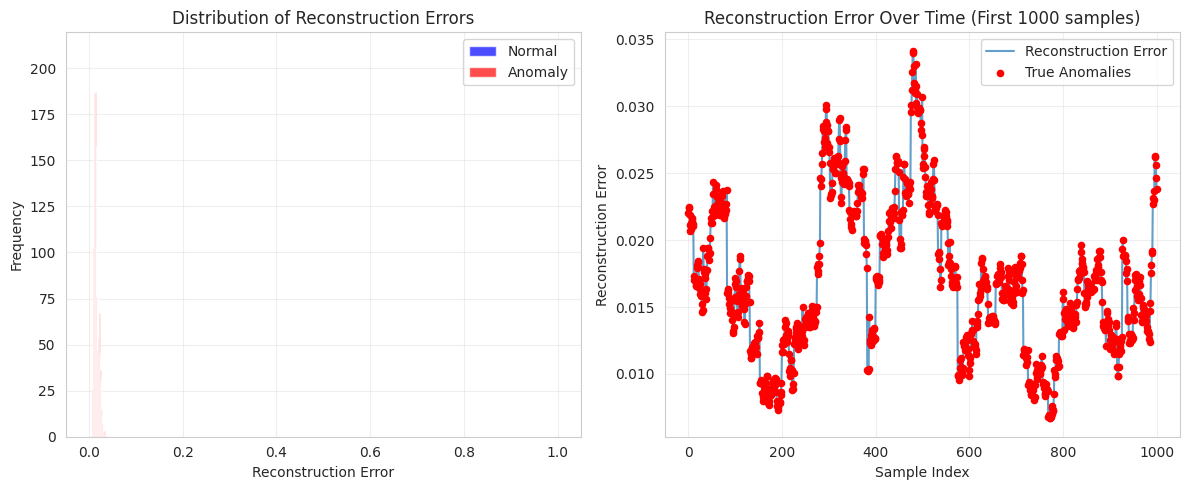

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


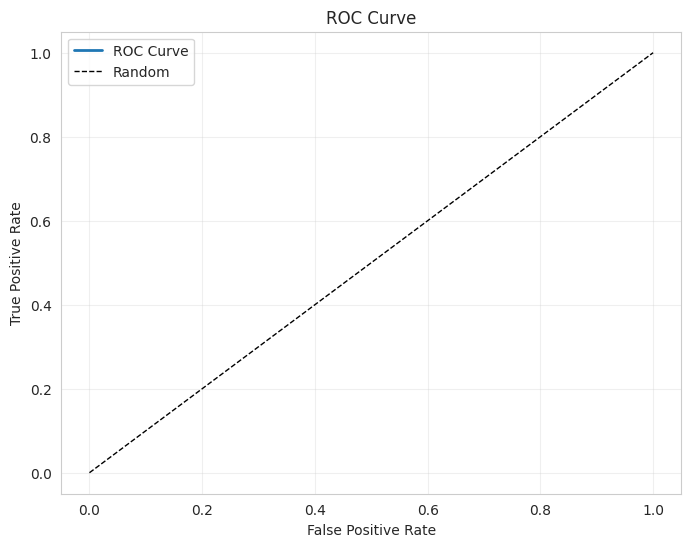

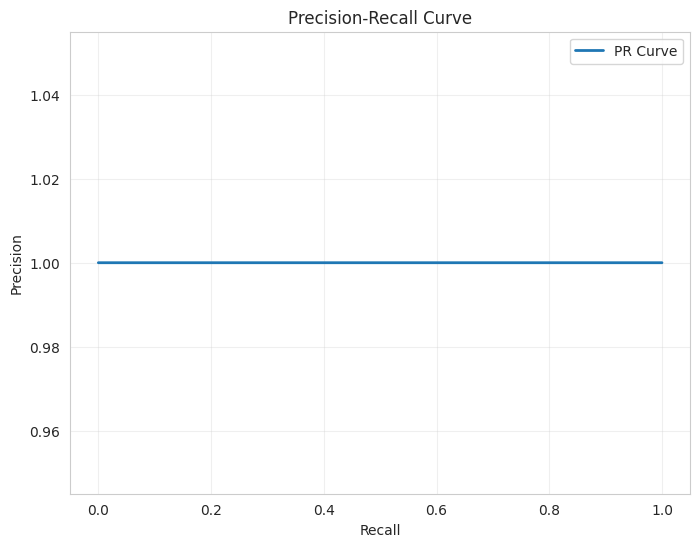

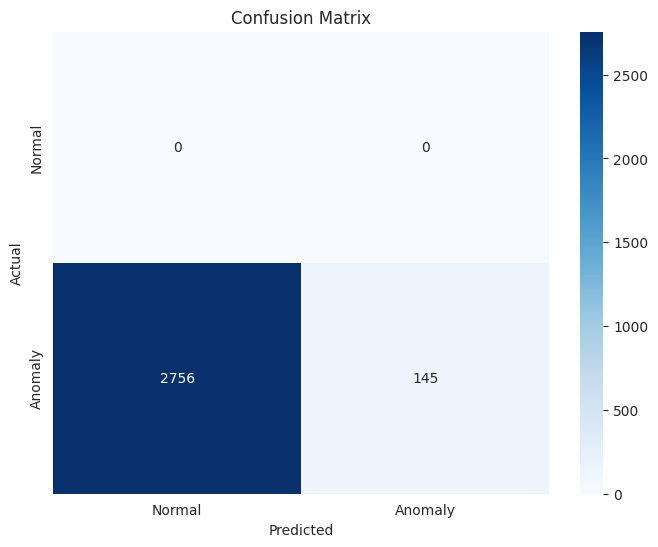

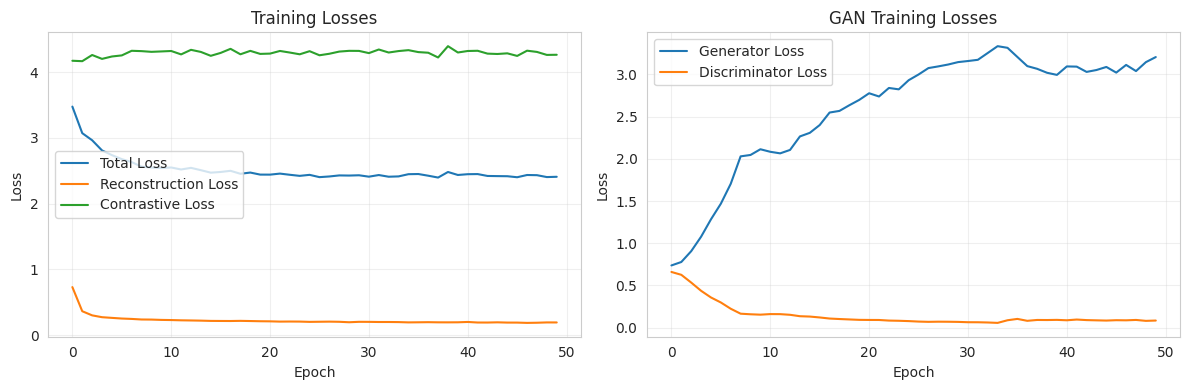


✅ All results saved to 'results/' directory!


In [41]:
import numpy as np
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

os.makedirs('results', exist_ok=True)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# ---------------------------------------------------------
# Utility: Convert numpy values → Python-native types
# ---------------------------------------------------------
def to_python(obj):
    if isinstance(obj, dict):
        return {k: to_python(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [to_python(i) for i in obj]
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj

# ---------------------------------------------------------
# 1. Reconstruction error distribution
# ---------------------------------------------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(all_reconstruction_errors[all_labels == 0], bins=50, alpha=0.7, label='Normal', color='blue')
plt.hist(all_reconstruction_errors[all_labels == 1], bins=50, alpha=0.7, label='Anomaly', color='red')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(all_reconstruction_errors[:1000], label='Reconstruction Error', alpha=0.7)
anomaly_indices = np.where(all_labels[:1000] == 1)[0]
if len(anomaly_indices) > 0:
    plt.scatter(anomaly_indices, all_reconstruction_errors[anomaly_indices],
               color='red', s=20, label='True Anomalies', zorder=5)
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error Over Time (First 1000 samples)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('results/reconstruction_errors.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------------------------------------
# 2. ROC Curve
# ---------------------------------------------------------
try:
    fpr, tpr, _ = roc_curve(all_labels, all_reconstruction_errors)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('results/roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
except:
    pass

# ---------------------------------------------------------
# 3. Precision–Recall Curve
# ---------------------------------------------------------
try:
    precision, recall, _ = precision_recall_curve(all_labels, all_reconstruction_errors)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, linewidth=2, label='PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('results/pr_curve.png', dpi=300, bbox_inches='tight')
    plt.show()
except:
    pass

# ---------------------------------------------------------
# 4. Confusion Matrix
# ---------------------------------------------------------
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('results/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------------------------------------
# 5. Training History
# ---------------------------------------------------------
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Total Loss')
plt.plot(history['recon_loss'], label='Reconstruction Loss')
plt.plot(history['contrastive_loss'], label='Contrastive Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True, alpha=0.3)

if config['use_gan']:
    plt.subplot(1, 2, 2)
    plt.plot(history['gan_g_loss'], label='Generator Loss')
    plt.plot(history['gan_d_loss'], label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('GAN Training Losses')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------------------------------------
# 6. Save metrics safely
# ---------------------------------------------------------
metrics_clean = to_python(metrics)

with open('results/metrics.json', 'w') as f:
    json.dump(metrics_clean, f, indent=2)

print("\n✅ All results saved to 'results/' directory!")


## ✅ Training and Evaluation Complete!

All results have been saved:
- Model checkpoint: `checkpoints/best_model.pt`
- Evaluation metrics: `results/metrics.json`
- Visualizations: `results/*.png`

The framework successfully integrated:
- ✅ Geometric Masking
- ✅ Transformer Architecture
- ✅ Contrastive Learning
- ✅ GAN Components
